Jose Jimenez

Quantitative Analyst

<a href='mailto:jimenez.jm@hotmail.com'>jimenez.jm@hotmail.com</a>

### Cox-Ross-Rubinstein model (Binomial option pricing)

In [3]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from scipy.integrate import quad
mpl.rcParams['font.family'] = 'serif'
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

In [4]:
def dN(x):
    ''' Probability density function of standard normal random variable x. '''
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)


def N(d):
    ''' Cumulative density function of standard normal random variable x. '''
    return quad(lambda x: dN(x), -20, d, limit=50)[0]


def d1f(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton d1 function.
        Parameters see e.g. BSM_call_value function. '''
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2)
          * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

#
# Valuation Functions
#


def BSM_call_value(St, K, t, T, r, sigma):
    ''' Calculates Black-Scholes-Merton European call option value.

    Parameters
    ==========
    St : float
        stock/index level at time t
    K : float
        strike price
    t : float
        valuation date
    T : float
        date of maturity/time-to-maturity if t = 0; T > t
    r : float
        constant, risk-less short rate
    sigma : float
        volatility

    Returns
    =======
    call_value : float
        European call present value at t
    '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value


def BSM_put_value(St, K, t, T, r, sigma):
    ''' Calculates Black-Scholes-Merton European put option value.

    Parameters
    ==========
    St : float
        stock/index level at time t
    K : float
        strike price
    t : float
        valuation date
    T : float
        date of maturity/time-to-maturity if t = 0; T > t
    r : float
        constant, risk-less short rate
    sigma : float
        volatility

    Returns
    =======
    put_value : float
        European put present value at t
    '''
    put_value = BSM_call_value(St, K, t, T, r, sigma) \
        - St + math.exp(-r * (T - t)) * K
    return put_value


#
# Plotting European Option Values
#


def plot_values(function):
    ''' Plots European option values for different parameters c.p. '''
    plt.figure(figsize=(10, 8.3))
    points = 100
    #
    # Model Parameters
    #
    St = 100.0  # index level
    K = 100.0  # option strike
    t = 0.0  # valuation date
    T = 1.0  # maturity date
    r = 0.05  # risk-less short rate
    sigma = 0.2  # volatility

    # C(K) plot
    plt.subplot(221)
    klist = np.linspace(80, 120, points)
    vlist = [function(St, K, t, T, r, sigma) for K in klist]
    plt.plot(klist, vlist)
    plt.grid()
    plt.xlabel('strike $K$')
    plt.ylabel('present value')

    # C(T) plot
    plt.subplot(222)
    tlist = np.linspace(0.0001, 1, points)
    vlist = [function(St, K, t, T, r, sigma) for T in tlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.xlabel('maturity $T$')

    # C(r) plot
    plt.subplot(223)
    rlist = np.linspace(0, 0.1, points)
    vlist = [function(St, K, t, T, r, sigma) for r in rlist]
    plt.plot(tlist, vlist)
    plt.grid(True)
    plt.xlabel('short rate $r$')
    plt.ylabel('present value')
    plt.axis('tight')

    # C(sigma) plot
    plt.subplot(224)
    slist = np.linspace(0.01, 0.5, points)
    vlist = [function(St, K, t, T, r, sigma) for sigma in slist]
    plt.plot(slist, vlist)
    plt.grid(True)
    plt.xlabel('volatility $\sigma$')
    plt.tight_layout()

In [5]:
#
# Cox-Ross-Rubinstein Binomial Model
# European Option Valuation
#

#
# Model Parameters
#
S0 = 100.0  # index level
K = 100.0  # option strike
T = 1.0  # maturity date
r = 0.05  # risk-less short rate
sigma = 0.2  # volatility


# Valuation Function
def CRR_option_value(S0, K, T, r, sigma, otype, M=4):
    ''' Cox-Ross-Rubinstein European option valuation.

    Parameters
    ==========
    S0 : float
        stock/index level at time 0
    K : float
        strike price
    T : float
        date of maturity
    r : float
        constant, risk-less short rate
    sigma : float
        volatility
    otype : string
        either 'call' or 'put'
    M : int
        number of time intervals
    '''
    # Time Parameters
    dt = T / M  # length of time interval
    df = math.exp(-r * dt)  # discount per interval

    # Binomial Parameters
    u = math.exp(sigma * math.sqrt(dt))  # up movement
    d = 1 / u  # down movement
    q = (math.exp(r * dt) - d) / (u - d)  # martingale branch probability

    # Array Initialization for Index Levels
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md

    # Inner Values
    if otype == 'call':
        V = np.maximum(S - K, 0)  # inner values for European call option
    else:
        V = np.maximum(K - S, 0)  # inner values for European put option

    z = 0
    for t in range(M - 1, -1, -1):  # backwards iteration
        V[0:M - z, t] = (q * V[0:M - z, t + 1] +
                         (1 - q) * V[1:M - z + 1, t + 1]) * df
        z += 1
    return V[0, 0]


def plot_convergence(mmin, mmax, step_size):
    ''' Plots the CRR option values for increasing number of time
    intervals M against the Black-Scholes-Merton benchmark value.'''
    BSM_benchmark = BSM_call_value(S0, K, 0, T, r, sigma)
    m = range(mmin, mmax, step_size)
    CRR_values = [CRR_option_value(S0, K, T, r, sigma, 'call', M) for M in m]
    plt.figure(figsize=(9, 5))
    plt.plot(m, CRR_values, label='CRR values')
    plt.axhline(BSM_benchmark, color='r', ls='dashed', lw=1.5,
                label='BSM benchmark')
    plt.xlabel('# of binomial steps $M$')
    plt.ylabel('European call option value')
    plt.legend(loc=4)
    plt.xlim(0, mmax)

### Binomial Option Pricing

In [6]:
BSM_benchmark = BSM_call_value(S0, K, 0, T, r, sigma)
BSM_benchmark

10.45058357218553

In [7]:
%time CRR_option_value(S0, K, T, r, sigma, 'call', M=2000)

Wall time: 380 ms


10.449583775457942

Wall time: 1.61 s


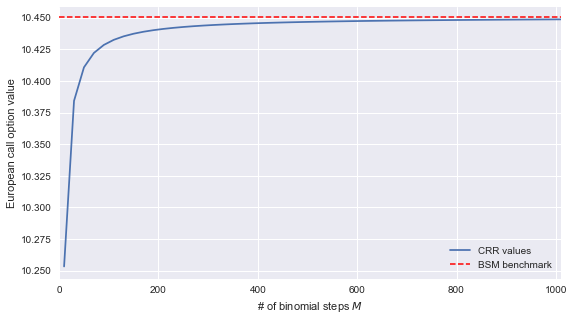

In [8]:
%%time
plot_convergence(10, 1011, 20)

Wall time: 1.33 s


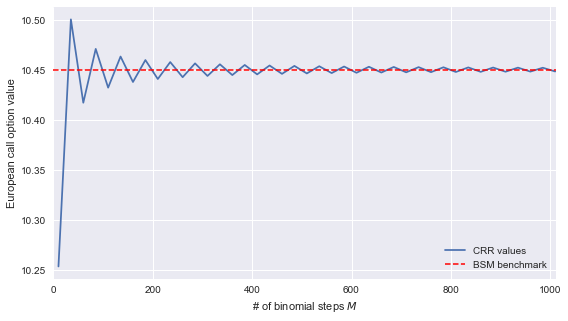

In [9]:
%%time
plot_convergence(10, 1011, 25)